<a href="https://colab.research.google.com/github/ulgenklc/Sarcastic-Tweet-Detection/blob/main/sentiment_analysis_singh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

**By Neuromatch Academy**

__Content creators:__  Juan Manuel Rodriguez, Salomey Osei, Gonzalo Uribarri

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Step 1: Questions and goals

* Can we infer emotion from a tweet text?
* How words are distributed accross the dataset?
* Are words related to one kind of emotion?

---
# Step 2: Literature review

[Original Dataset Paper](https://cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

[Papers with code](https://paperswithcode.com/dataset/imdb-movie-reviews)

---
# Step 3: Load and explore the dataset

##  Install dependencies


In [ ]:
# @title Install dependencies
!pip install pandas --quiet
!pip install torchtext --quiet

In [7]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

We are going to clone in the git repository for the project to access additional datasets and code. 

In [2]:
!git clone 'https://github.com/ulgenklc/Sarcastic-Tweet-Detection.git'

Cloning into 'Sarcastic-Tweet-Detection'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 60 (delta 23), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (60/60), done.


Next we are going to load the sarcasm dataset. This data comes from multiple sources (1 = The Onion, 2 = Reddit, 3 = iSarcasm dataset of Tweets


In [9]:
import zipfile, io

!unzip '/content/Sarcastic-Tweet-Detection/mergedSarcasm.zip'
mergedSarcasm = pd.read_csv('mergedSarcasm.csv')
mergedSarcasm.head()

Archive:  /content/Sarcastic-Tweet-Detection/mergedSarcasm.zip
replace mergedSarcasm.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: mergedSarcasm.csv       


,Unnamed: 0,comment,label,Source
0,0,former versace store clerk sues over secret 'b...,False,1
1,1,the 'roseanne' revival catches up to our thorn...,False,1
2,2,mom starting to fear son's web series closest ...,True,1
3,3,"boehner just wants wife to listen, not come up...",True,1
4,4,j.k. rowling wishes snape happy birthday in th...,False,1


You can find the dataset we are going to use in [this website](http://help.sentiment140.com/for-students/).

In [ ]:
import requests, zipfile, io
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
# We load the dataset
header_list = ["polarity", "id", "date", "query", "user", "text"]
df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                 encoding = "ISO-8859-1", names=header_list)

# Let's have a look at it
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


For this project we will use only the text and the polarity of the tweet. Notice that polarity is 0 for negative tweets and 4 for positive tweet.

In [ ]:
# print(df.shape)
len(df['user'].unique())

659775

In [ ]:
df.text.values[4]

"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "

In [ ]:
X = df.text.values
print(X.shape)
# Changes values from [0,4] to [0,1]
y = (df.polarity.values > 1).astype(int)


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

(1600000,)


The first thing we have to do before working on the models is to familiarize ourselves with the dataset. This is called Exploratory Data Analisys (EDA).

In [ ]:
df1 = df.copy()

In [ ]:
#remove URLs
import re
pattern=r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))';
def rem_url(x):
  match = re.findall(pattern, x)
  for m in match:
    url = m[0]
    x = x.replace(url, '')
  return x

df1['url_removed'] = df1['text'].apply(lambda x:rem_url(x))
# df1.head()

In [ ]:
#remove twitter handles from text
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
df1['handle_removed'] = df1['url_removed'].apply(lambda x:tknzr.tokenize(x))
# df1.head()

In [ ]:
# detokenize the tweet again
from nltk.tokenize.treebank import TreebankWordDetokenizer
df1['orig'] = df1['handle_removed'].apply(lambda x:TreebankWordDetokenizer().detokenize(x))

# df1.head()

In [ ]:
# remove punctuations
import string
string.punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
df1['clean_msg']= df1['orig'].apply(lambda x:remove_punctuation(x))
# df1.head()

,polarity,id,date,query,user,text,url_removed,handle_removed,orig,clean_msg
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot - Awww, that's a bummer. You sho...","[-, Awww, ,, that's, a, bummer, ., You, should...","- Awww, that's a bummer . You shoulda got Davi...",Awww thats a bummer You shoulda got David Ca...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can't, update, his, Face...",is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...,"[I, dived, many, times, for, the, ball, ., Man...",I dived many times for the ball . Managed to s...,I dived many times for the ball Managed to sa...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...",my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all....","[no, ,, it's, not, behaving, at, all, ., i'm, ...","no, it's not behaving at all . i'm mad . why a...",no its not behaving at all im mad why am i h...


In [ ]:
# delete the unnecessary columns
del df1['url_removed']
del df1['handle_removed']
del df1['orig']
# df1.head()

,polarity,id,date,query,user,text,clean_msg
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats a bummer You shoulda got David Ca...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sa...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i h...


In [ ]:
# remove the upper case letters
df1['msg_lower'] = df1['clean_msg'].apply(lambda x: x.lower())
# df1.head()

,polarity,id,date,query,user,text,clean_msg,msg_lower
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats a bummer You shoulda got David Ca...,awww thats a bummer you shoulda got david ca...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,is upset that he cant update his facebook by t...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sa...,i dived many times for the ball managed to sa...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i h...,no its not behaving at all im mad why am i h...


In [ ]:
# tokenize
import re
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens
#applying function to the column
# df1['msg_tokenied']= df1['msg_lower'].apply(lambda x: tokenization(x))
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
df1['msg_tokenied'] = df1['msg_lower'].apply(lambda x:tknzr.tokenize(x))
# df1.head()

,polarity,id,date,query,user,text,clean_msg,msg_lower,msg_tokenied
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats a bummer You shoulda got David Ca...,awww thats a bummer you shoulda got david ca...,"[awww, thats, a, bummer, you, shoulda, got, da..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,is upset that he cant update his facebook by t...,"[is, upset, that, he, cant, update, his, faceb..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sa...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i h...,no its not behaving at all im mad why am i h...,"[no, its, not, behaving, at, all, im, mad, why..."


In [ ]:
# removing stop words
#importing nlp library
import nltk
nltk.download('stopwords')
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')
# stopwords[0:10]
#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

#applying the function
df1['no_stopwords']= df1['msg_tokenied'].apply(lambda x:remove_stopwords(x))
# df1.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,polarity,id,date,query,user,text,clean_msg,msg_lower,msg_tokenied,no_stopwords
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats a bummer You shoulda got David Ca...,awww thats a bummer you shoulda got david ca...,"[awww, thats, a, bummer, you, shoulda, got, da...","[awww, thats, bummer, shoulda, got, david, car..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,is upset that he cant update his facebook by t...,"[is, upset, that, he, cant, update, his, faceb...","[upset, cant, update, facebook, texting, itand..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sa...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i h...,no its not behaving at all im mad why am i h...,"[no, its, not, behaving, at, all, im, mad, why...","[behaving, im, mad, cant, see]"


In [ ]:
#importing the Stemming function from nltk library
from nltk.stem.porter import PorterStemmer
#defining the object for stemming
porter_stemmer = PorterStemmer()
#defining a function for stemming
def stemming(text):
  stem_text = [porter_stemmer.stem(word) for word in text]
  return stem_text

df1['msg_stemmed']=df1['no_stopwords'].apply(lambda x: stemming(x))
# df1.head()

,polarity,id,date,query,user,text,clean_msg,msg_lower,msg_tokenied,no_stopwords,msg_stemmed
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats a bummer You shoulda got David Ca...,awww thats a bummer you shoulda got david ca...,"[awww, thats, a, bummer, you, shoulda, got, da...","[awww, thats, bummer, shoulda, got, david, car...","[awww, that, bummer, shoulda, got, david, carr..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,is upset that he cant update his facebook by t...,"[is, upset, that, he, cant, update, his, faceb...","[upset, cant, update, facebook, texting, itand...","[upset, cant, updat, facebook, text, itand, mi..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sa...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...","[dive, mani, time, ball, manag, save, 50, rest..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i h...,no its not behaving at all im mad why am i h...,"[no, its, not, behaving, at, all, im, mad, why...","[behaving, im, mad, cant, see]","[behav, im, mad, cant, see]"


In [ ]:
from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
#defining the function for lemmatization
def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

df1['msg_lemmatized']=df1['no_stopwords'].apply(lambda x:lemmatizer(x))
# df1.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,polarity,id,date,query,user,text,clean_msg,msg_lower,msg_tokenied,no_stopwords,msg_stemmed,msg_lemmatized
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats a bummer You shoulda got David Ca...,awww thats a bummer you shoulda got david ca...,"[awww, thats, a, bummer, you, shoulda, got, da...","[awww, thats, bummer, shoulda, got, david, car...","[awww, that, bummer, shoulda, got, david, carr...","[awww, thats, bummer, shoulda, got, david, car..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...,is upset that he cant update his facebook by t...,"[is, upset, that, he, cant, update, his, faceb...","[upset, cant, update, facebook, texting, itand...","[upset, cant, updat, facebook, text, itand, mi...","[upset, cant, update, facebook, texting, itand..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sa...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...","[dive, mani, time, ball, manag, save, 50, rest...","[dived, many, time, ball, managed, save, 50, r..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]","[whole, body, feel, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i h...,no its not behaving at all im mad why am i h...,"[no, its, not, behaving, at, all, im, mad, why...","[behaving, im, mad, cant, see]","[behav, im, mad, cant, see]","[behaving, im, mad, cant, see]"


In [ ]:
# detokenize the tweet again
df2 = df1.copy()

from nltk.tokenize.treebank import TreebankWordDetokenizer
df2['orig'] = df2['msg_lemmatized'].apply(lambda x:TreebankWordDetokenizer().detokenize(x))

del df2['msg_lower']
del df2['text']
del df2['clean_msg']
df2.head()

,polarity,id,date,query,user,msg_tokenied,no_stopwords,msg_stemmed,msg_lemmatized,orig
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"[awww, thats, a, bummer, you, shoulda, got, da...","[awww, thats, bummer, shoulda, got, david, car...","[awww, that, bummer, shoulda, got, david, carr...","[awww, thats, bummer, shoulda, got, david, car...",awww thats bummer shoulda got david carr third...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,"[is, upset, that, he, cant, update, his, faceb...","[upset, cant, update, facebook, texting, itand...","[upset, cant, updat, facebook, text, itand, mi...","[upset, cant, update, facebook, texting, itand...",upset cant update facebook texting itand might...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...","[dive, mani, time, ball, manag, save, 50, rest...","[dived, many, time, ball, managed, save, 50, r...",dived many time ball managed save 50 rest go b...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]","[whole, body, feel, itchy, like, fire]",whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"[no, its, not, behaving, at, all, im, mad, why...","[behaving, im, mad, cant, see]","[behav, im, mad, cant, see]","[behaving, im, mad, cant, see]",behaving im mad cant see


In [ ]:
df2.columns

Index(['polarity', 'id', 'date', 'query', 'user', 'msg_tokenied',
       'no_stopwords', 'msg_stemmed', 'msg_lemmatized', 'orig'],
      dtype='object')

In [ ]:
# let's play with the lemmatized text to see how it's accuracy fairs
X = df2.orig.values
print(X.shape)
# Changes values from [0,4] to [0,1]
y = (df2.polarity.values > 1).astype(int)


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

(1600000,)


In [ ]:
for s, l in zip(x_train_text[:5], y_train[:5]):
  print('{}: {}'.format(l, s))

1: lol get idea far advance even june yet need third knitter summer group
0: worst headache ever
0: sad wont see miss already yeah thats perfect come back 18th
1: doesnt know spell conked
0: stand one know u wont get used wont get used gone miss home everyone


An interesting thing to analyze is the Word Distribution. In order to count the occurrences of each word, we should tokenize the sentences first.

In [ ]:
tokenizer = get_tokenizer("basic_english")

# print('Before Tokenize: ', x_train_text[4])
# print('After Tokenize: ', tokenizer(x_train_text[4]))

In [ ]:
x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

We can count the words occurences and see how many different words are present in our dataset.

In [ ]:
words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:10])

Number of different Tokens in our Dataset: 362498
['im', 'day', 'good', 'get', 'like', 'go', 'u', 'love', 'dont', 'work']


Now we can plot their distribution.

In [ ]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

The 0.7809698260404195% most common words account for the 80.00089475101471% of the occurrences


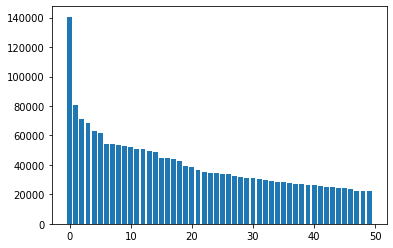

In [ ]:
plt.bar(range(50), [words[w] for w in sorted_words[:50]])
plt.show()

In [ ]:
for w in sorted_words[:10]:
  print(w, words[w])

im 140607
day 80885
good 71403
get 68756
like 63286
go 61696
u 54274
love 53871
dont 53452
work 52673


It is very common to find this kind of distribution when analyzing corpus of text. This is referred to as the [zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law).

Usually the number of words in the dictionary will be very large. 

Here are some thing we can do to reduce that number:

* Remove puntuation.
* Remove stop-words.
* Steaming.
* Remove very uncommon words (the words that appears in fewer than N occations).
* Nothing: we can use a pretrain model that handles this kind of situations.


We used one of the simplest tokenizers availables. This tokenizer does not take into account many quirks of the language. Moreover, diferent languages have different quirks, so there is no "universal" tokenizers. There are many libraries that have "better" tokenizers:

* [Spacy](https://spacy.io/): it can be accessed using: `get_tokenizer("spacy")`. Spacy supports a wide range of languages.
* [Huggingface](https://huggingface.co/): it has many tokenizers for different laguages. [Doc](https://huggingface.co/transformers/main_classes/tokenizer.html)
* [NLTK](https://www.nltk.org/): it provides several tokenizers. One of them can be accessed using: `get_tokenizer("toktok")`


---
# Step 4: choose toolkit

Our goal is to train a model capable of estimating the sentiment of a tweet (positive or negative) by reading its content. To that end we will try 2 different approaches:

* A logistic regression using sklearn. **NOTE**: it can probaly work better than an SVM model.
* A simple Embedding + RNN.

## Logistic regression

We will represent our senteces using binary vectorization. This means that our data would be represented as a matrix of instances by word with a one if the word is in the instance, and zero otherwise. Sklean vectorizers can also do things such as stop-word removal and puntuation removal, you can read more about in [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [ ]:
vectorizer = CountVectorizer(binary=True)
x_train_cv = vectorizer.fit_transform(x_train_text)
x_test_cv = vectorizer.transform(x_test_text)

In [ ]:
print('Before Vectorize: ', x_train_text[3])

Before Vectorize:  doesnt know spell conked


In [ ]:
# Notice that the matriz is sparse
print('After Vectorize: ')
print(x_train_cv[3])

After Vectorize: 
  (0, 91379)	1
  (0, 173243)	1
  (0, 289588)	1
  (0, 72815)	1


Now we can train our model. You can check the documentation of this logistic regressor [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logistic#sklearn.linear_model.LogisticRegression).

In [ ]:
model = LogisticRegression(solver='saga')
model.fit(x_train_cv, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# prediction with lemmatized words
y_pred = model.predict(x_test_cv)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78    160000
           1       0.77      0.80      0.79    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [ ]:
# prediction with unprocessed text
y_pred = model.predict(x_test_cv)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78    160000
           1       0.77      0.80      0.79    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



## Explainable AI
The best thing about logistic regresion is that it is simple, and we can get some explanations.

In [ ]:
print(model.coef_.shape)
print(len(vectorizer.vocabulary_))

words_sk = list(vectorizer.vocabulary_.keys())
words_sk.sort(key=lambda w: model.coef_[0, vectorizer.vocabulary_[w]])

(1, 362380)
362380


In [ ]:
for w in words_sk[:20]:
  print('{}: {}'.format(w, model.coef_[0, vectorizer.vocabulary_[w]]))

inaperfectworld: -3.652249114481632
dontyouhate: -3.4552512490970204
pakcricket: -3.4107268523575596
nanda: -3.2303101907274474
sad: -3.2238588234199264
saddens: -3.0706366889390218
devastated: -3.035777475484703
sadd: -3.018690113738346
sadface: -3.0090942791626123
heartbreaking: -3.007975755212785
disappointing: -3.0004436572069366
condolence: -2.978793877811033
bummed: -2.9019619056202837
roni: -2.8928033856257813
saddest: -2.860821907812469
booooo: -2.845754021147026
heartbroken: -2.8398865700450204
saddd: -2.815942861976383
upsetting: -2.8118892682140273
sadly: -2.808691903199809


In [ ]:
for w in reversed(words_sk[-20:]):
  print('{}: {}'.format(w, model.coef_[0, vectorizer.vocabulary_[w]]))

fuzzball: 3.2278468167571734
myfax: 3.060886166579027
homebased: 2.904808493499516
wooohooo: 2.445789935402008
smilin: 2.443763268973308
congratulation: 2.3822022531484
dampen: 2.343890033551911
yayness: 2.2685837766707353
smiling: 2.2059802702716595
honored: 2.1518998138231584
nemonemesis: 2.1502687182714126
twittz: 2.124499999242595
grinning: 2.0872535377222095
emailunlimited: 2.0771946070034573
optimism: 2.0640099596993835
merrier: 2.050189835994396
yeyy: 2.049778247709612
worryi: 2.043996361679062
welcome: 2.0344146290377587
gefeliciteerd: 1.9924731974294414


What does this mean?

Remember the `model.coef_` is the $W$ in:

$$h(x)=\sigma(WX + b)$$

where the label 1 is a positive tweet and the label 0 is a negative tweet.

## Recurrent Neural Network with Pytorch

In the previous section we use a Bag-Of-Words approach to represent each of the tweets. That meas that we only consider how many times each of the words appear in each of the tweets, we didnt take into account the order of the words. But we know that the word order is very important and carries relevant information.

In this section we will solve the same task, but this time we will implement a Recurrent Neural Network (RNN) instead of using a simple Logistic Regression.Unlike feedforward neural networks, RNNs have cyclic connections making them powerful for modeling sequences.

Let's start by importing the relevant libraries.


In [ ]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
# Set the device (check if gpu is available)
device = set_device()

GPU is enabled in this notebook.


First we will create a Dictionary (`word_to_idx`). This dictionary will map each Token (usually words) to an index (an integer number). We want to limit our dictionary to a certain number of tokens (`num_words_dict`), so we will include in our ditionary those with more occurrences.

In [ ]:
# From previous section, we have a list with the most used tokens
sorted_words[:10]

['im', 'day', 'good', 'get', 'like', 'go', 'u', 'love', 'dont', 'work']

Let's select only the most used.

In [ ]:
num_words_dict = 30000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

We will add two extra Tokens to the dictionary, one for words outside the dictionary (`'UNK'`) and one for padding the sequences (`'PAD'`).

In [ ]:
# dictionary to go from words to idx 
word_to_idx = {}
# dictionary to go from idx to words (just in case) 
idx_to_word = {}


# We include the special tokens first
PAD_token = 0   
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word

Our goal now is to transform each tweet from a sequence of tokens to a sequence of indexes. These sequences of indexes will be the input to our pytorch model.

In [ ]:
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx

In [ ]:
x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)

In [ ]:
some_number = 1
print('Before converting: ', x_train_token[some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['worst', 'headache', 'ever']
After converting:  [595, 337, 144]


We need all the sequences to have the same length. To select an adequate sequence length, let's explore some statistics about the length of the tweets:

In [ ]:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  302
Mean tweet word length:  7.0
99% percent under:  17.0


We cut the sequences which are larger than our chosen maximum length (`max_lenght`) and fill with zeros the ones that are shorter.

In [ ]:
 # We choose the max length
 max_length = 20

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
 def padding(sentences, seq_len):
  features = np.zeros((len(sentences), seq_len),dtype=int)
  for ii, tweet in enumerate(sentences):
    len_tweet = len(tweet) 
    if len_tweet != 0:
      if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
        features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
      if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
        features[ii, :] = np.array(tweet)[-seq_len:]
  return features

In [ ]:
# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

In [ ]:
some_number = 2
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [49, 114, 23, 33, 120, 76, 46, 553, 50, 17, 3003]
After padding:  [   0    0    0    0    0    0    0    0    0   49  114   23   33  120
   76   46  553   50   17 3003]


Now, let's convert the data to pytorch format.


In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

Each batch of data in our traning proccess will have the folllowing format:

In [ ]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 20])
Sample input: 
 tensor([[    0,     0,     0,  ...,   757,    15,    11],
        [    0,     0,     0,  ...,     0,  1246,   269],
        [    0,     0,     0,  ...,   234,  5039,  2762],
        ...,
        [    0,     0,     0,  ...,   223,   840,    26],
        [    0,     0,     0,  ...,   606,   106,     1],
        [    0,     0,     0,  ...,    90,   193, 24188]])
Sample input: 
 tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1])


Now, we will define the `SentimentRNN` class. Most of the model's class will be familiar to you, but there are two important layers we would like you to pay attention to:

*   Embedding Layer
> This layer is like a linear layer, but it makes it posible to use a sequence of inedexes as inputs (instead of a sequence of one-hot-encoded vectors). During training, the Embedding layer learns a linear transformation from the space of words (a vector space of dimension `num_words_dict`) into the a new, smaller, vector space of dimension `embedding_dim`. We suggest you to read this [thread](https://discuss.pytorch.org/t/how-does-nn-embedding-work/88518/3) and the [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) if you want to learn more about this particular kind of layers.


*   LSTM layer
> This is one of the most used class of Recurrent Neural Networks. In Pytorch we can add several stacked layers in just one line of code. In our case, the number of layers added are decided with the parameter `no_layers`. If you want to learn more about LSTMs we strongly recommend you this [Colahs thread](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) about them.







In [ ]:
class SentimentRNN(nn.Module):
  def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.1):
    super(SentimentRNN,self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size
    self.drop_prob = drop_prob

    # Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)

    # LSTM Layers
    self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                        num_layers=no_layers, batch_first=True, 
                        dropout=self.drop_prob)

    # Dropout layer
    self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.sig = nn.Sigmoid()
      
  def forward(self,x,hidden):
    batch_size = x.size(0)

    # Embedding out
    embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # LSTM out
    lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # Sigmoid function
    sig_out = self.sig(out)

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
    hidden = (h0,c0)
    return hidden

We choose the parameters of the model.

In [ ]:
# Parameters of our network

# Size of our vocabulary
vocab_size = num_words_dict

# Embedding dimension
embedding_dim = 32

# Number of stacked LSTM layers
no_layers = 2

# Dimension of the hidden layer in LSTMs
hidden_dim = 64

# Dropout parameter for regularization
output_dim = 1

# Dropout parameter for regularization
drop_prob = 0.25

In [ ]:
# Let's define our model
model = SentimentRNN(no_layers, vocab_size, hidden_dim,
                     embedding_dim, drop_prob=drop_prob)
# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(30000, 32)
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  1018433


We choose the losses and the optimizer for the training procces.

In [ ]:
# loss and optimization functions
lr = 0.001

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.BCELoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

We are ready to train our model.

In [ ]:
# Number of training Epochs
epochs = 5

# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()
  
  for inputs, labels in train_loader:

    # Initialize hidden state 
    h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
    h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
    model.zero_grad()

    # Compute model output
    output,h = model(inputs,h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    train_losses.append(loss.item())

    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  
  # Evaluate on the validation set for this epoch 
  val_losses = []
  val_acc = 0.0
  model.eval()
  for inputs, labels in valid_loader:

    # Initialize hidden state 
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.float())

    val_losses.append(val_loss.item())

    accuracy = acc(output,labels)
    val_acc += accuracy
          
  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}') 
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

Epoch 1
train_loss : 0.486832209257409 val_loss : 0.45346609644591807
train_accuracy : 76.199453125 val_accuracy : 78.5709375
Validation loss decreased (inf --> 0.453466).  Saving model ...
Epoch 2
train_loss : 0.4421832159953192 val_loss : 0.44210863079875706
train_accuracy : 79.2871875 val_accuracy : 79.2021875
Validation loss decreased (0.453466 --> 0.442109).  Saving model ...
Epoch 3
train_loss : 0.42780291808070614 val_loss : 0.437168142516166
train_accuracy : 80.123203125 val_accuracy : 79.5484375
Validation loss decreased (0.442109 --> 0.437168).  Saving model ...
Epoch 4
train_loss : 0.41718389569432474 val_loss : 0.43680137969087807
train_accuracy : 80.74710937500001 val_accuracy : 79.655625
Validation loss decreased (0.437168 --> 0.436801).  Saving model ...
Epoch 5
train_loss : 0.4078306574071757 val_loss : 0.43908808412030337
train_accuracy : 81.25250000000001 val_accuracy : 79.57843749999999


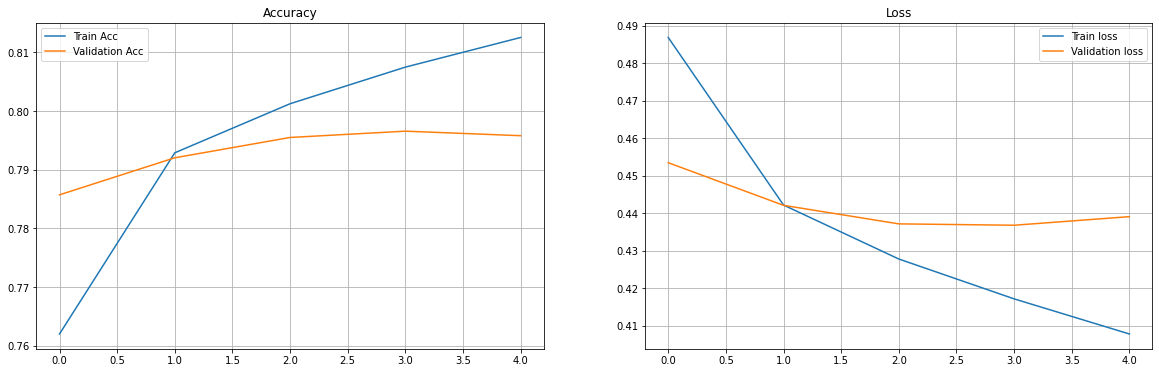

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

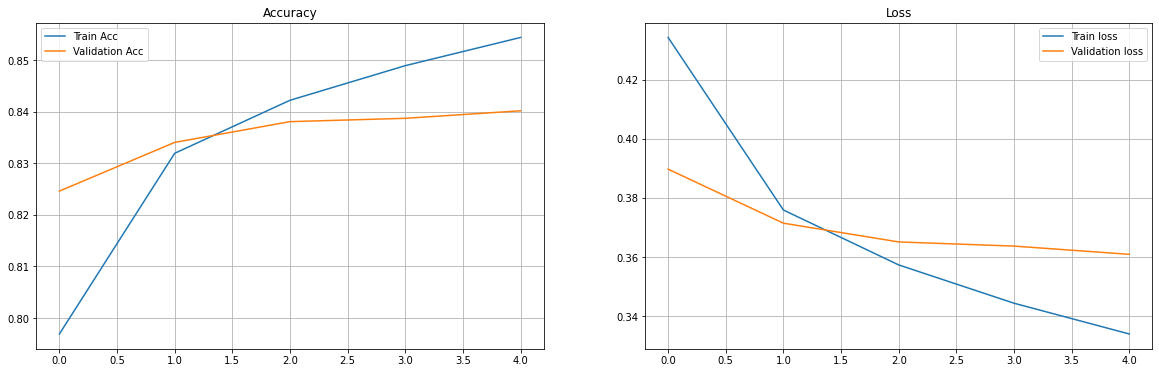

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

---
# What's Next?

You can use this project template as a starting point to think about your own project. There are a lot of ways to continue, here we share with you some ideas you migth find useful:

*   **Work on the Preproccesing.** We used a very rudimentary way to tokenize tweets. But there are better ways to preprocess the data. Can you think of a suitable way to preprocess the data for this particular task? How does the performance of the model change when the data is processed correctly?
*   **Work on the Model.** The RNN model proposed in this notebook is not optimized at all. You can work on finding a better architecture or better hyperparamenters. May be using bidirectonal LSTMs or increasing the number of stacked layers can improve the performance, feel free to try different approaches.
*   **Work on the Embedding.** Our model learnt an embedding during the training on this Twitter corpus for a particular task. You can explore the representation of different words in this learned embedding. Also, you can try using different word embeddings. You can train them on this corpus or you can use an embedding trained on another corpus of data. How does the change of the embedding affect the model performance?
*   **Try sentiment analysis on another dataset.** There are lots of available dataset to work with, we can help you find one that is interesting to you. Do you belive that a sentiment analysis model trained on some corpus (Twitter dataset) will perform well on another type of data (for example, youtube comments)?

